In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


plt.rcParams['figure.figsize'] = [16, 8]

In [91]:
df = pd.read_csv('../data/ee_joined.csv')
mp = pd.read_csv('../data/mp_joined.csv')

## Merging big wall cliffs to MP data.

Running a merging operation to join the two dataframes. Earth Engine could not handle this calculation.

In [92]:
df['mp_counts'] = 0
df['num_rock_routes'] = 0
df['num_views'] = 0
df['distance_to_mp'] = None

for i, row in tqdm(df.iterrows(), total=df.shape[0]):
    filtered = mp[mp.custom_index == row.custom_index]
    mp_count = filtered.shape[0]
    if mp_count:
        df.at[i, 'mp_counts'] = mp_count
        df.at[i, 'num_rock_routes'] = filtered.num_rock_routes.sum()
        df.at[i, 'num_views'] = filtered.num_views.sum()
        df.at[i, 'distance_to_mp'] = filtered.distance_to_mp.mean()

100%|██████████| 35229/35229 [00:29<00:00, 1198.59it/s]


Now everything we need is inside the `df` dataframe. Dropping some left-over columns from Earth Engine.

In [93]:
df.drop(columns=['system:index', 'centroid', 'centroid_lith', 'custom_index', 'vicinity_mp_areas'], inplace=True)
df.columns

Index(['B2', 'B4', 'B42', 'B5', 'B6', 'B65', 'B67', 'B7', 'geology_alluvium',
       'geology_carbonate', 'geology_colluvial_sediment',
       'geology_glacial_till_coarse', 'geology_non_carbonate',
       'geology_silicic_residual', 'height', 'latitude', 'longitude',
       'pixel_count', 'population_within_100km', 'population_within_200km',
       'population_within_30km', 'road_within_1000m', 'road_within_1500m',
       'road_within_2000m', 'road_within_3000m', 'road_within_500m',
       'vicinity_num_rock_routes', 'vicinity_num_views', '.geo', 'mp_counts',
       'num_rock_routes', 'num_views', 'distance_to_mp'],
      dtype='object')

## Exploring association between big wall cliffs and MP data

Checking out the cliffs with associated MP areas. Many MP areas have their geo-tags well aligned with the location of the cliff according to earth engine.

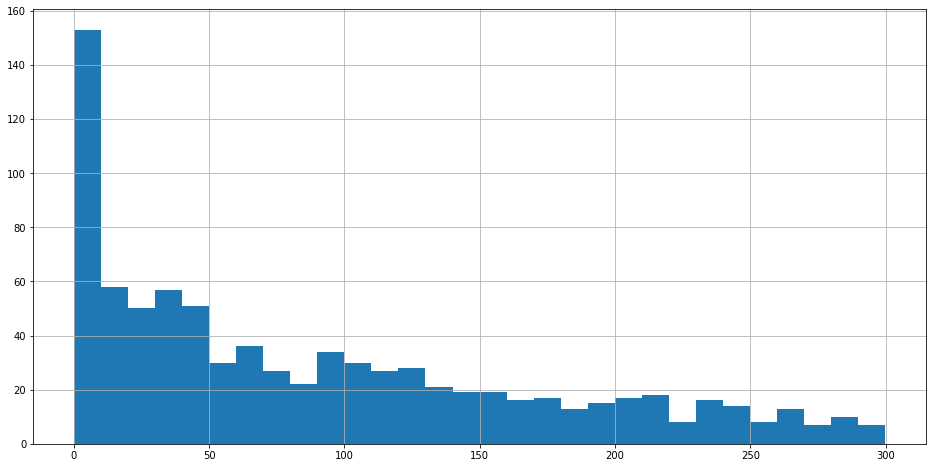

In [94]:
df.distance_to_mp.hist(bins=30)

Most cliffs have no associated MP areas. Some have many.

In [42]:
for n in range(20):
    print((df.mp_counts == n).sum())

34388
637
111
43
17
15
5
6
3
0
2
1
1
0
0
0
0
0
0
0


Are big walls viewed more on MP? Not really...

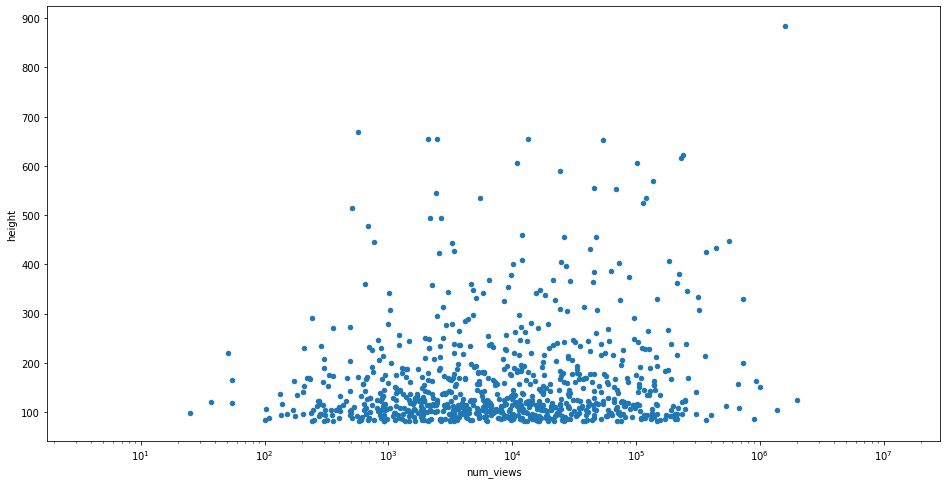

In [58]:
df[df.num_views > 0].plot(x='num_views', y='height', kind='scatter', logx=True);

But, as expected, big wall MP areas with more routes do get more views.

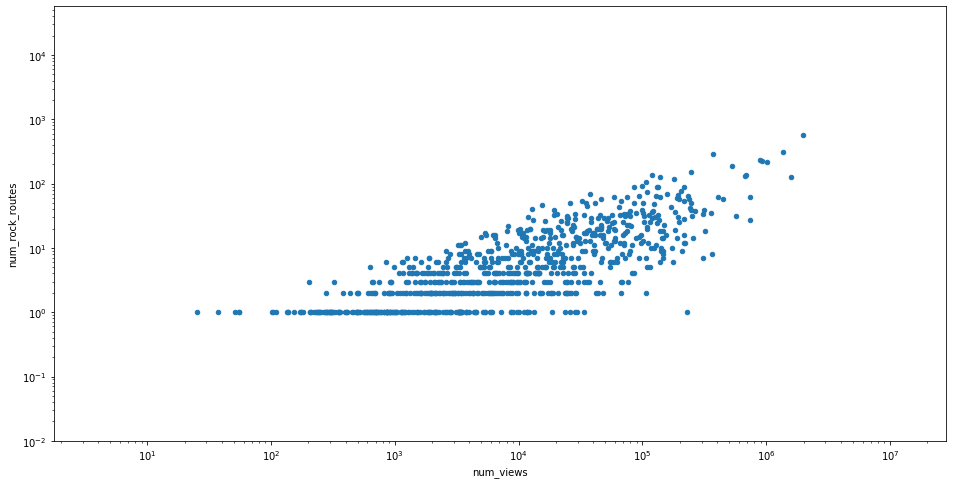

In [59]:
df[df.num_views > 0].plot(x='num_views', y='num_rock_routes', kind='scatter', loglog=True);

Cliffs for which MP geo tag doesn't align well with cliff location according to Earth Engine elevation data. These can be cross-referenced with the script in `ee_code_editor/explore_unmerged_data.js`

In [95]:
df[df.distance_to_mp > 200][['latitude', 'longitude', 'height', 'num_rock_routes', 'distance_to_mp']].head(20)

,latitude,longitude,height,num_rock_routes,distance_to_mp
128,36.067025,-112.144964,262,8,206.853
689,37.732670,-119.574832,555,21,202.635
1515,38.045084,-107.677194,81,19,243.84
1576,37.098237,-118.521364,81,4,265.047
1738,37.247971,-112.964622,337,4,275.244
1973,37.626450,-110.584673,82,3,230.104
2039,36.099268,-115.483981,82,1,243.467
2040,36.062065,-115.479574,82,5,212.144
2041,36.086375,-115.477075,82,1,213.928
2172,38.693802,-109.541441,82,2,243.607


Eventually, we'll partition the data into two classes -- those that are accessible (and hence explored), and those that are inaccessible. Checking out possible classes here. The classes below are not disjoint!

In [82]:
print(f'Number of cliffs with MP entry: {(df.mp_counts > 0).sum()}')
print(f'Number of obscure cliffs with MP entry: {((df.mp_counts > 0) & (df.num_views < 1000)).sum()}')
print(f'Number of cliffs with MP in vicinity: {(df.vicinity_num_rock_routes > 0).sum()}')
print(f'Number of cliffs with nearby road: {(df.road_within_500m == 1).sum()}')
print(f'Number of cliffs with nearby town: {(df.population_within_30km > 30_000).sum()}')
print(f'Number of cliffs with somewhat close city: {(df.population_within_100km > 1_000_000).sum()}')

Number of cliffs with MP entry: 841
Number of obscure cliffs with MP entry: 133
Number of cliffs with MP in vicinity: 2701
Number of cliffs with nearby road: 3837
Number of cliffs with nearby town: 1656
Number of cliffs with somewhat close city: 2914


In [99]:
accessible = (df.num_views > 1000) | (df.vicinity_num_views > 10000) | ((df.road_within_500m == 1) & (df.population_within_30km > 30_000)) | \
             ((df.road_within_500m == 1) & (df.population_within_100km > 1_000_000))
print(f'Number of accessibles: {accessible.sum()}')
print(f'Number of positives: {(df.num_views > 1000).sum()}')

Number of accessibles: 2121
Number of positives: 708


This is somewhat bad news -- we have a very small training set, and the training set is unbalanced. Smaller is better than nothing.

## Noise in the elevation data

There are "holes" in the elevation dataset found at 'USGS/NED'. These holes give the appearance of deep wells within the elevation data. They form regions in which the elevation at several pixels is much lower than all of the surrounding elevation, and hence give "false positives". Manually removing these holds after studying the plot of height vs pixel_count. This removes roughly 1000 data points. Points above the red line are removed.

       height   latitude   longitude  pixel_count  num_rock_routes
34763    1517  38.914940 -105.447284           21                0
36       1281  38.694518 -114.250813          129                0
34018    1243  35.680132 -118.371031           69                0
20675    1141  41.125010 -106.000602          147                0
20676    1141  41.125766 -106.000017            1                0
20677    1141  41.125676 -105.999867            6                0
20678    1141  41.124774 -105.999837           23                0
20330     884  37.731722 -119.635903         2448              125
18849     880  48.971787 -121.002191          206                0
18850     880  48.975689 -120.995760          701                0
956       840  48.910145 -113.704846         1536                0
207       777  48.040483 -121.512820          621                0
35050     759  48.898919 -113.861067         1143                0
34650     746  47.780878 -121.581563         5125             

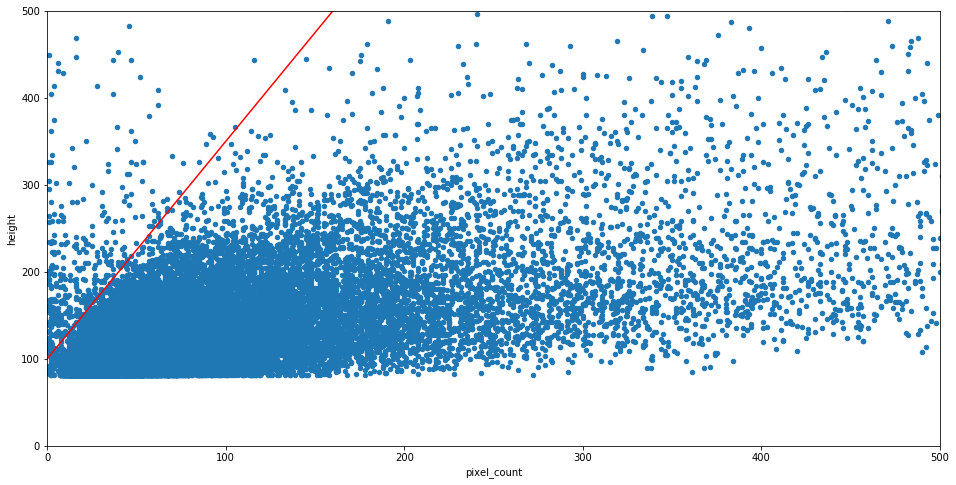

Number of data points removed: 591


In [140]:
print(df[df.height > 500].sort_values(by='height', ascending=False)[['height', 'latitude', 'longitude', 'pixel_count', 'num_rock_routes']][:20])

df.plot(x='pixel_count', y='height', kind='scatter', xlim=(0, 500), ylim=(0, 500))
line = lambda x: 2.5 * x + 100
plt.plot([0, 1000], [line(0), line(1000)], 'k-', color='red')
plt.show()
filt = (df.height < 2.5 * df.pixel_count + 100) & (df.pixel_count > 10)
print(f'Number of data points removed: {(~filt).sum()}')
df = df[filt]

Below is old stuff that needs to be updated with current dataset.

In [278]:
df = pd.read_csv('../data/merged_data')

# Dropping columns we don't care about.
df = df.drop(columns=['system:index', 'centroid_lith', '.geo'])

# There are "holes" in the elevation dataset found at 'USGS/NED'. These holes
# give the appearance of deep wells within the elevation data. They form regions
# in which the elevation at several pixels is much lower than all of the
# surrounding elevation, and hence give "false positives". Manually removing
# these holds after studying the plot of height vs pixel_count. This removes
# roughly 100 data points.
df = df[(df.height < 2.5 * df.pixel_count + 100) & (df.pixel_count > 7)]

# Values in landsat and geology columns do not need scaling. They are already
# distributed somewhat normally around 0 with standard deviation close to 1. We
# do remove landsat bands with negative values -- around 11 of these.
df = df[(df.B2 > 0) & (df.B4 > 0) & (df.B5 > 0) & (df.B6 > 0) & (df.B7 > 0)]

# Reassigning pixel_count to a ratio.
df.pixel_count /= df.height

# Scaling height so that it is contained between 0 and 1.
df.height /= 1000

# Weighting the "target"-values logarithmically.
df.mp_score = df.mp_score.map(lambda x: 0 if x < 5000 else np.log2(x) / 20)

df = df.reset_index(drop=True)


# We will train the model using cliffs that have both large populations and
# roads nearby.
accessible = (df.road_within_1000m == 1) & (df.population_within_100km > 10000)
inaccessible = df.road_within_3000m == 0

df = df.drop(columns=['road_within_1000m', 'road_within_2000m',
'road_within_3000m', 'road_within_4000m', 'road_within_5000m',
'population_within_30km', 'population_within_100km'])

explored = df[accessible]
unexplored = df[inaccessible]

In [279]:
explored

,B2,B4,B42,B5,B6,B65,B67,B7,geology_alluvium,geology_carbonate,geology_colluvial_sediment,geology_glacial_till_coarse,geology_non_carbonate,geology_silicic_residual,height,latitude,longitude,mp_score,pixel_count
0,0.080879,0.031780,0.392936,0.088698,0.033984,0.383148,2.228190,0.015252,0.000000,0.0,0.0,0.0,1.000000,0.000000,0.097,42.822238,-124.313063,0.0,0.309278
2,0.109952,0.083274,0.757361,0.107151,0.103531,0.966215,1.373784,0.075362,0.000000,0.0,0.0,0.0,1.000000,0.000000,0.083,39.886942,-123.918287,0.0,0.180723
3,0.112904,0.075220,0.666228,0.148984,0.116810,0.784043,1.438436,0.081206,0.000000,0.0,0.0,0.0,1.000000,0.000000,0.107,39.873938,-123.913047,0.0,0.420561
8,0.088705,0.034374,0.387508,0.041069,0.012033,0.292993,1.643290,0.007322,0.045134,0.0,0.0,0.0,0.184995,0.769871,0.085,45.346812,-123.980048,0.0,0.329412
9,0.101851,0.057838,0.567868,0.202906,0.076108,0.375088,1.957644,0.038877,0.389618,0.0,0.0,0.0,0.012641,0.597741,0.086,45.489309,-123.974722,0.0,0.674419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34751,0.088904,0.075709,0.851583,0.161498,0.141879,0.878522,1.503072,0.094393,0.000000,0.0,0.0,0.0,0.815968,0.184032,0.090,37.096162,-104.464025,0.0,0.511111
34752,0.090916,0.075544,0.830916,0.177727,0.143121,0.805288,1.525441,0.093823,0.000000,0.0,0.0,0.0,0.352090,0.647910,0.094,37.075679,-104.451602,0.0,0.265957
34754,0.079696,0.037315,0.468216,0.041209,0.038482,0.933817,1.191994,0.032284,0.000000,0.0,0.0,0.0,1.000000,0.000000,0.131,31.004003,-104.060401,0.0,0.496183
34756,0.128860,0.149445,1.159745,0.253556,0.302971,1.194888,1.372499,0.220744,0.000000,0.0,0.0,0.0,0.770306,0.000000,0.189,38.052207,-103.000390,0.0,0.211640


In [275]:
X = explored.drop(columns=['latitude', 'longitude', 'mp_score']).values
y = explored.mp_score.values

In [277]:
y

array([0., 0., 0., ..., 0., 0., 0.])

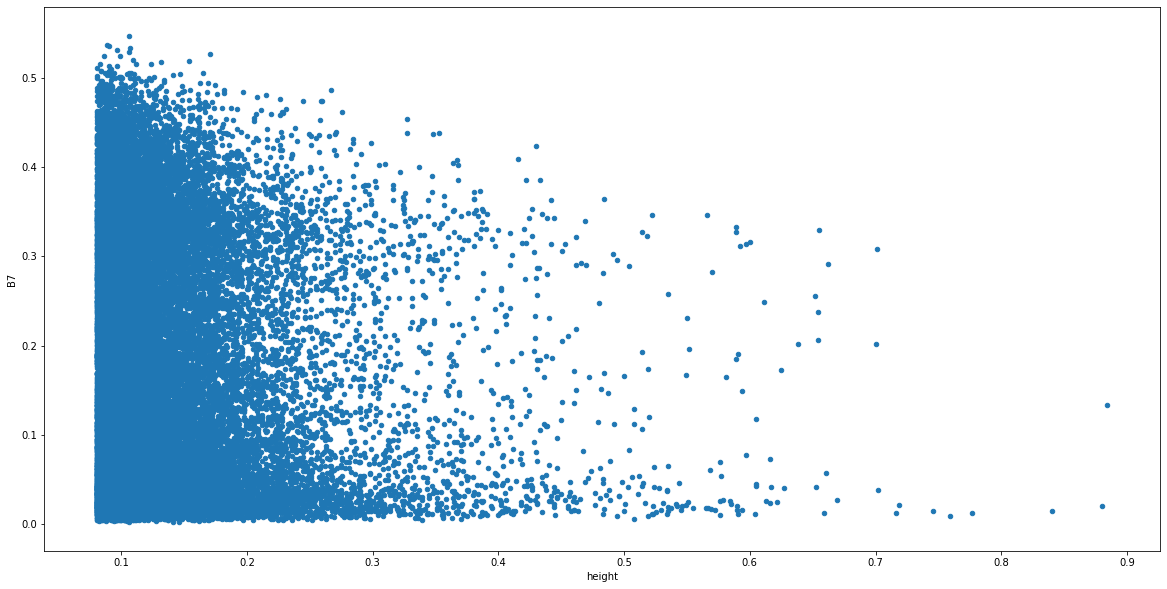

In [170]:
df.plot(x='height', y='B7', kind='scatter')

(34769, 29)


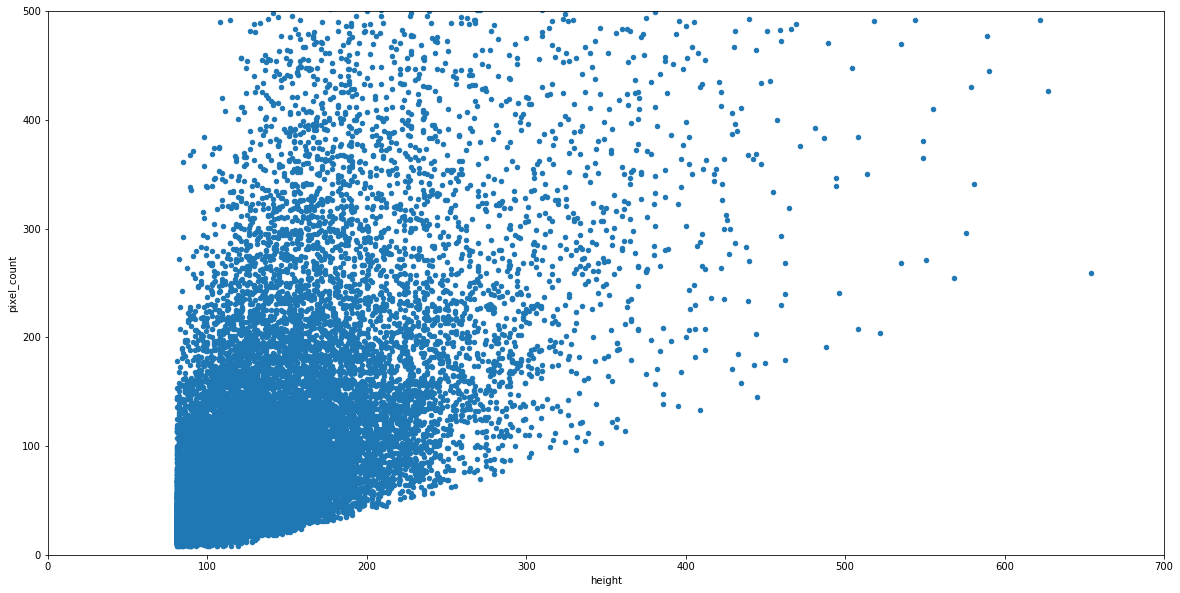

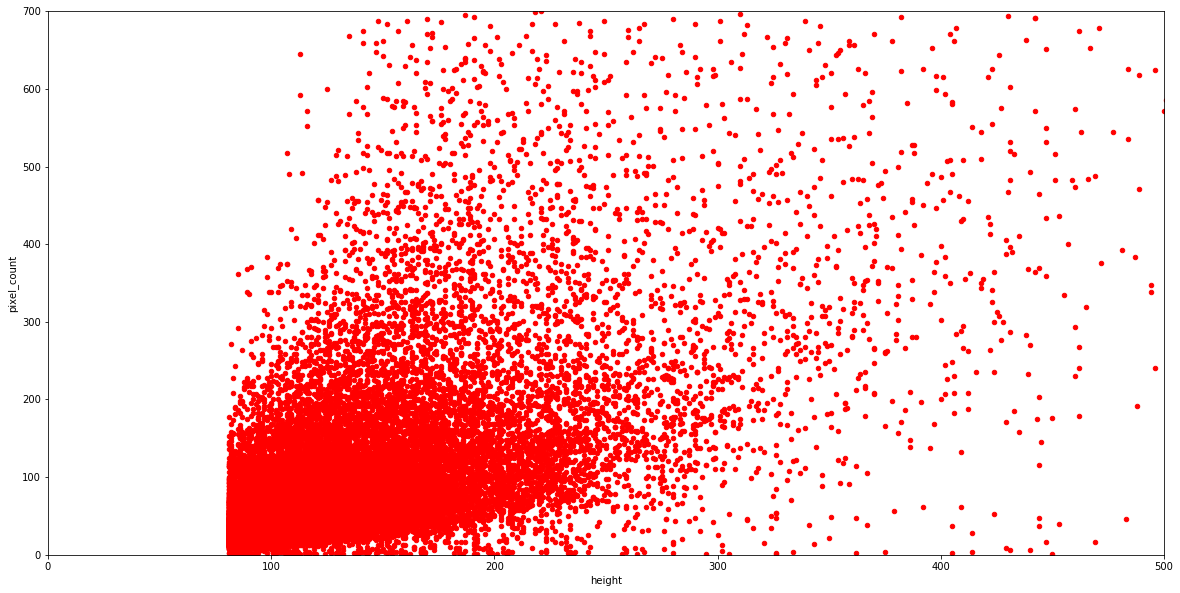

In [94]:
a = a.assign(ratio=pd.Series(a.height / a.pixel_count).values)

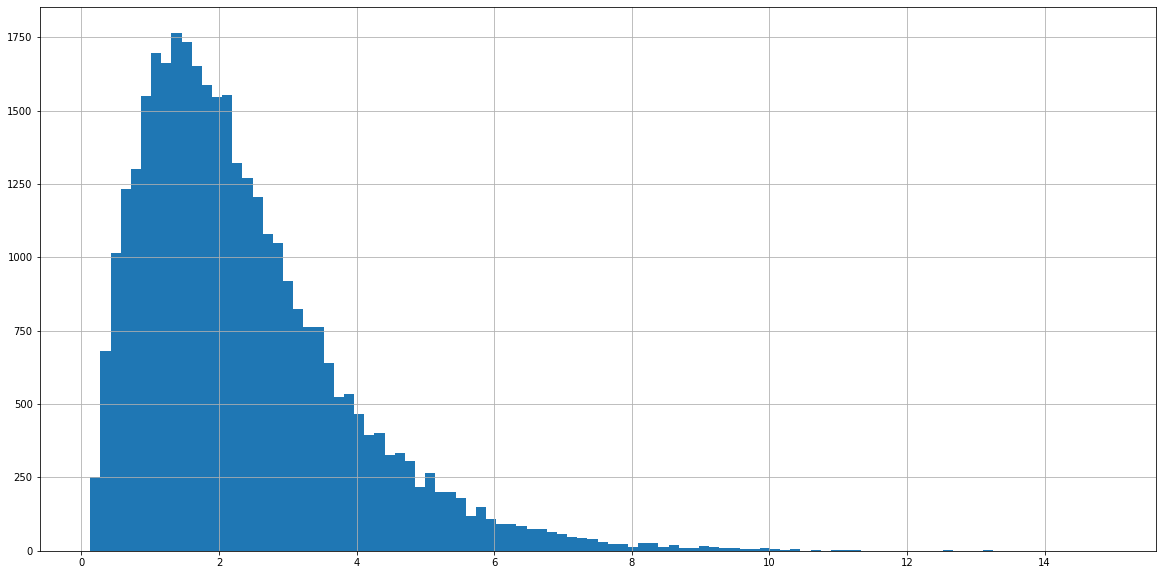

In [83]:
a.ratio.hist(bins=100)

In [97]:
a[(a.ratio > 2.5) & (a.height > 500)][['height', 'latitude', 'longitude']]

,height,latitude,longitude
1353,522,48.222226,-121.664904
7763,654,46.310325,-114.248479


In [63]:
a[a.height > 800][['latitude', 'longitude']]

,latitude,longitude
3868,48.975689,-120.995760
4404,37.731722,-119.635903
10814,48.910145,-113.704846


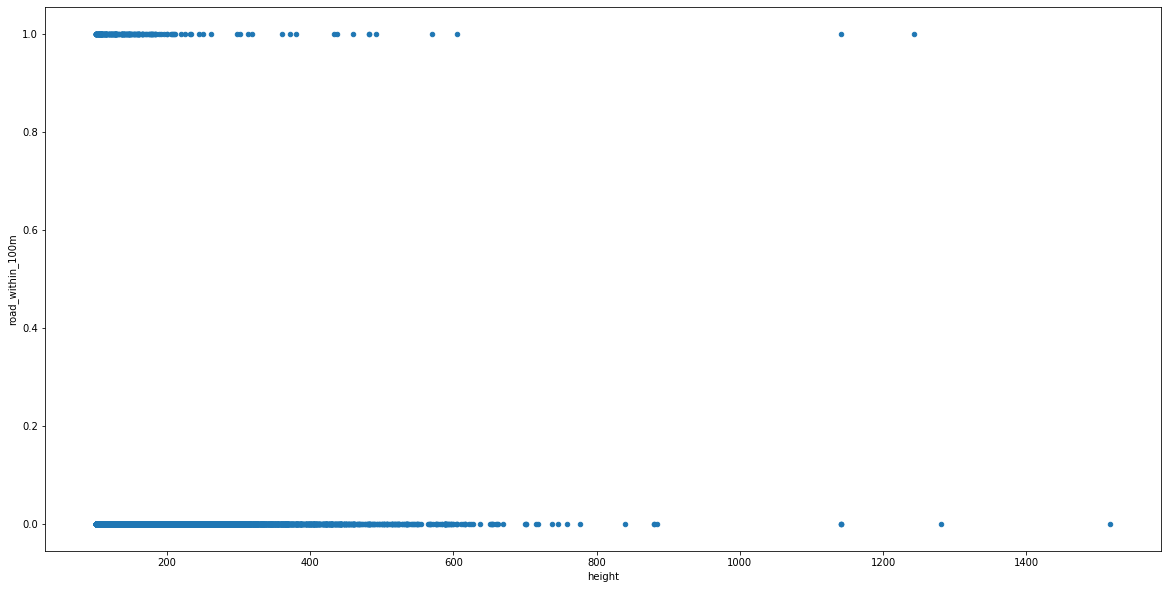

In [5]:
df.plot(x='height', y='road_within_100m', kind='scatter')#, xlim=(0, 600), ylim=(0, 20))

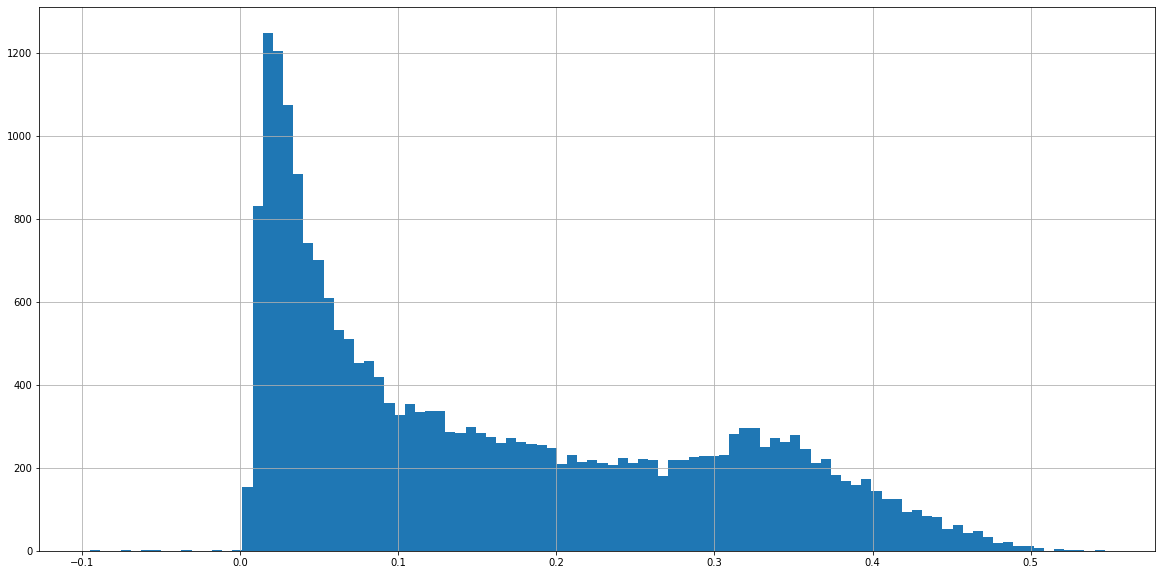

In [6]:
df.B7.hist(bins=100)

In [95]:
df.height *= 1000

In [96]:
df.height

0        156.0
1        182.0
2        107.0
3        108.0
4        182.0
         ...  
22938    110.0
22939    147.0
22940    131.0
22941    189.0
22942    118.0
Name: height, Length: 22943, dtype: float64

In [23]:
df[df.road_within_3000m == 1]

,system:index,B2,B4,B42,B5,B6,B65,B67,B7,centroid_lith,...,latitude,longitude,pixel_count,population_within_100km,population_within_30km,road_within_1000m,road_within_100m,road_within_3000m,road_within_300m,.geo
0,+523076+304095,0.081164,0.038796,0.477994,0.267884,0.084211,0.314355,2.501339,0.033666,3,...,42.683131,-124.010470,54,308563,1081,0,0,1,0,"{""type"":""Point"",""coordinates"":[-124.0104699919..."
1,+523200+274547,0.099478,0.066427,0.667755,0.324934,0.169146,0.520556,1.987414,0.085109,19,...,45.337023,-124.000055,2,991317,18916,0,0,1,0,"{""type"":""Point"",""coordinates"":[-124.0000545253..."
2,+524171+335371,0.112904,0.075220,0.666228,0.148984,0.116810,0.784043,1.438436,0.081206,3,...,39.873938,-123.913047,45,97855,5515,1,0,1,0,"{""type"":""Point"",""coordinates"":[-123.9130466930..."
3,+524690+303277,0.087868,0.053528,0.609189,0.097629,0.078045,0.799398,1.383273,0.056420,5,...,42.756743,-123.865972,41,391276,1304,0,0,1,0,"{""type"":""Point"",""coordinates"":[-123.8659721857..."
4,+523204+274547,0.103282,0.066515,0.644014,0.279917,0.151935,0.542785,1.958009,0.077597,19,...,45.338244,-123.990883,517,1016269,19038,0,0,1,0,"{""type"":""Point"",""coordinates"":[-123.9908825093..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22938,+739015+421772,0.084867,0.048230,0.568300,0.079769,0.072466,0.908454,1.542522,0.046979,1,...,32.111825,-104.613803,41,52711,214,0,0,1,0,"{""type"":""Point"",""coordinates"":[-104.6138026739..."
22939,+738322+357492,0.101503,0.085985,0.847118,0.260340,0.211241,0.811403,1.655106,0.127630,3,...,37.886363,-104.675558,32,313464,6353,0,0,1,0,"{""type"":""Point"",""coordinates"":[-104.6755578508..."
22940,+745187+434103,0.079696,0.037315,0.468216,0.041209,0.038482,0.933817,1.191994,0.032284,3,...,31.004003,-104.060401,65,28519,151,1,0,1,0,"{""type"":""Point"",""coordinates"":[-104.0604009370..."
22941,+756968+355643,0.128860,0.149445,1.159745,0.253556,0.302971,1.194888,1.372499,0.220744,3,...,38.052207,-103.000390,40,53373,6747,1,0,1,1,"{""type"":""Point"",""coordinates"":[-103.0003896360..."


In [120]:
df[df.road_within_3000m == 1].shape

(12565, 27)

In [117]:
df[(df.population_within_100km > 10000) & (df.road_within_1000m)]

,system:index,B2,B4,B42,B5,B6,B65,B67,B7,centroid_lith,...,latitude,longitude,population_within_100km,population_within_30km,ratio_height_to_area,road_within_1000m,road_within_100m,road_within_3000m,road_within_300m,.geo
2,+524171+335371,0.112904,0.075220,0.666228,0.148984,0.116810,0.784043,1.438436,0.081206,3,...,39.873938,-123.913047,97855,5515,2.377778,1,0,1,0,"{""type"":""Point"",""coordinates"":[-123.9130466930..."
6,+523416+267705,0.102405,0.044251,0.432116,0.107849,0.042966,0.398390,1.853286,0.023184,3,...,45.951883,-123.978685,419202,31633,1.656566,1,0,1,0,"{""type"":""Point"",""coordinates"":[-123.9786850379..."
7,+523482+267685,0.102595,0.040724,0.396938,0.086901,0.033160,0.381581,1.897035,0.017480,3,...,45.955322,-123.972653,424955,32088,0.694737,1,0,1,0,"{""type"":""Point"",""coordinates"":[-123.9726531249..."
8,+524663+269114,0.093500,0.065446,0.699966,0.340513,0.191306,0.561818,2.136370,0.089547,3,...,45.825733,-123.868605,1059251,18479,2.789474,1,0,1,0,"{""type"":""Point"",""coordinates"":[-123.8686049608..."
9,+525520+261887,0.112345,0.080551,0.716997,0.169931,0.154665,0.910167,1.760064,0.087875,3,...,46.474283,-123.794970,469517,20692,1.254902,1,1,1,1,"{""type"":""Point"",""coordinates"":[-123.7949701050..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22936,+738563+422146,0.160685,0.201686,1.255165,0.327707,0.407209,1.242602,1.387989,0.293380,1,...,32.078194,-104.653325,52434,236,2.861111,1,0,1,0,"{""type"":""Point"",""coordinates"":[-104.6533251772..."
22937,+738595+422147,0.130854,0.141694,1.082839,0.211643,0.294225,1.390193,1.388493,0.211902,3,...,32.078143,-104.651239,52436,236,2.276596,1,0,1,0,"{""type"":""Point"",""coordinates"":[-104.6512387316..."
22940,+745187+434103,0.079696,0.037315,0.468216,0.041209,0.038482,0.933817,1.191994,0.032284,3,...,31.004003,-104.060401,28519,151,2.015385,1,0,1,0,"{""type"":""Point"",""coordinates"":[-104.0604009370..."
22941,+756968+355643,0.128860,0.149445,1.159745,0.253556,0.302971,1.194888,1.372499,0.220744,3,...,38.052207,-103.000390,53373,6747,4.725000,1,0,1,1,"{""type"":""Point"",""coordinates"":[-103.0003896360..."


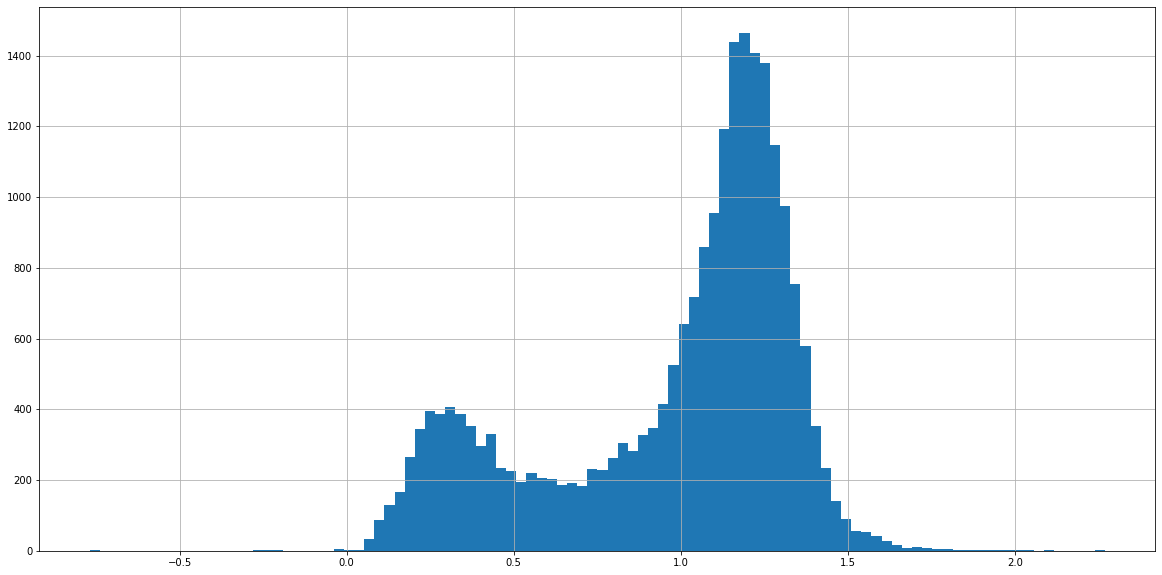

In [129]:
df.B65.hist(bins=100)

In [138]:
df[(df.B2 > 0) & (df.B4 > 0) & (df.B5 > 0) & (df.B6 > 0) & (df.B7 > 0)]

,system:index,B2,B4,B42,B5,B6,B65,B67,B7,centroid_lith,...,latitude,longitude,population_within_100km,population_within_30km,ratio_height_to_area,road_within_1000m,road_within_100m,road_within_3000m,road_within_300m,.geo
0,+523076+304095,0.081164,0.038796,0.477994,0.267884,0.084211,0.314355,2.501339,0.033666,3,...,42.683131,-124.010470,308563,1081,2.888889,0,0,1,0,"{""type"":""Point"",""coordinates"":[-124.0104699919..."
1,+523200+274547,0.099478,0.066427,0.667755,0.324934,0.169146,0.520556,1.987414,0.085109,19,...,45.337023,-124.000055,991317,18916,91.000000,0,0,1,0,"{""type"":""Point"",""coordinates"":[-124.0000545253..."
2,+524171+335371,0.112904,0.075220,0.666228,0.148984,0.116810,0.784043,1.438436,0.081206,3,...,39.873938,-123.913047,97855,5515,2.377778,1,0,1,0,"{""type"":""Point"",""coordinates"":[-123.9130466930..."
3,+524690+303277,0.087868,0.053528,0.609189,0.097629,0.078045,0.799398,1.383273,0.056420,5,...,42.756743,-123.865972,391276,1304,2.634146,0,0,1,0,"{""type"":""Point"",""coordinates"":[-123.8659721857..."
4,+523204+274547,0.103282,0.066515,0.644014,0.279917,0.151935,0.542785,1.958009,0.077597,19,...,45.338244,-123.990883,1016269,19038,0.352031,0,0,1,0,"{""type"":""Point"",""coordinates"":[-123.9908825093..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22938,+739015+421772,0.084867,0.048230,0.568300,0.079769,0.072466,0.908454,1.542522,0.046979,1,...,32.111825,-104.613803,52711,214,2.682927,0,0,1,0,"{""type"":""Point"",""coordinates"":[-104.6138026739..."
22939,+738322+357492,0.101503,0.085985,0.847118,0.260340,0.211241,0.811403,1.655106,0.127630,3,...,37.886363,-104.675558,313464,6353,4.593750,0,0,1,0,"{""type"":""Point"",""coordinates"":[-104.6755578508..."
22940,+745187+434103,0.079696,0.037315,0.468216,0.041209,0.038482,0.933817,1.191994,0.032284,3,...,31.004003,-104.060401,28519,151,2.015385,1,0,1,0,"{""type"":""Point"",""coordinates"":[-104.0604009370..."
22941,+756968+355643,0.128860,0.149445,1.159745,0.253556,0.302971,1.194888,1.372499,0.220744,3,...,38.052207,-103.000390,53373,6747,4.725000,1,0,1,1,"{""type"":""Point"",""coordinates"":[-103.0003896360..."


In [139]:
df

,system:index,B2,B4,B42,B5,B6,B65,B67,B7,centroid_lith,...,latitude,longitude,population_within_100km,population_within_30km,ratio_height_to_area,road_within_1000m,road_within_100m,road_within_3000m,road_within_300m,.geo
0,+523076+304095,0.081164,0.038796,0.477994,0.267884,0.084211,0.314355,2.501339,0.033666,3,...,42.683131,-124.010470,308563,1081,2.888889,0,0,1,0,"{""type"":""Point"",""coordinates"":[-124.0104699919..."
1,+523200+274547,0.099478,0.066427,0.667755,0.324934,0.169146,0.520556,1.987414,0.085109,19,...,45.337023,-124.000055,991317,18916,91.000000,0,0,1,0,"{""type"":""Point"",""coordinates"":[-124.0000545253..."
2,+524171+335371,0.112904,0.075220,0.666228,0.148984,0.116810,0.784043,1.438436,0.081206,3,...,39.873938,-123.913047,97855,5515,2.377778,1,0,1,0,"{""type"":""Point"",""coordinates"":[-123.9130466930..."
3,+524690+303277,0.087868,0.053528,0.609189,0.097629,0.078045,0.799398,1.383273,0.056420,5,...,42.756743,-123.865972,391276,1304,2.634146,0,0,1,0,"{""type"":""Point"",""coordinates"":[-123.8659721857..."
4,+523204+274547,0.103282,0.066515,0.644014,0.279917,0.151935,0.542785,1.958009,0.077597,19,...,45.338244,-123.990883,1016269,19038,0.352031,0,0,1,0,"{""type"":""Point"",""coordinates"":[-123.9908825093..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22938,+739015+421772,0.084867,0.048230,0.568300,0.079769,0.072466,0.908454,1.542522,0.046979,1,...,32.111825,-104.613803,52711,214,2.682927,0,0,1,0,"{""type"":""Point"",""coordinates"":[-104.6138026739..."
22939,+738322+357492,0.101503,0.085985,0.847118,0.260340,0.211241,0.811403,1.655106,0.127630,3,...,37.886363,-104.675558,313464,6353,4.593750,0,0,1,0,"{""type"":""Point"",""coordinates"":[-104.6755578508..."
22940,+745187+434103,0.079696,0.037315,0.468216,0.041209,0.038482,0.933817,1.191994,0.032284,3,...,31.004003,-104.060401,28519,151,2.015385,1,0,1,0,"{""type"":""Point"",""coordinates"":[-104.0604009370..."
22941,+756968+355643,0.128860,0.149445,1.159745,0.253556,0.302971,1.194888,1.372499,0.220744,3,...,38.052207,-103.000390,53373,6747,4.725000,1,0,1,1,"{""type"":""Point"",""coordinates"":[-103.0003896360..."


In [7]:
from geopy.distance import distance

In [9]:
d = distance((37.886363, -104.675558), (42.683131, -124.010470))
d.m

1723755.8626920318

In [10]:
mp = pd.read_csv('mp_data.csv')

In [158]:
df[['population_within_100km', 'population_within_30km', 'road_within_1000m', 'road_within_100m', 'road_within_3000m', 'road_within_300m']]

,population_within_100km,population_within_30km,road_within_1000m,road_within_100m,road_within_3000m,road_within_300m
0,308563,1081,0,0,1,0
1,991317,18916,0,0,1,0
2,97855,5515,1,0,1,0
3,391276,1304,0,0,1,0
4,1016269,19038,0,0,1,0
...,...,...,...,...,...,...
22938,52711,214,0,0,1,0
22939,313464,6353,0,0,1,0
22940,28519,151,1,0,1,0
22941,53373,6747,1,0,1,1


In [ ]:
def mp_score((latitude, longitude)):
    

In [99]:
df[(df.B2 < 0) | (df.B4 < 0) | (df.B5 < 0) | (df.B6 < 0) | (df.B7 < 0)]

,system:index,B2,B4,B42,B5,B6,B65,B67,B7,centroid_lith,...,mp_score,pixel_count,population_within_100km,population_within_30km,road_within_1000m,road_within_2000m,road_within_3000m,road_within_4000m,road_within_5000m,.geo
4640,+575287+356614,0.321950,0.382060,1.186704,0.239554,-0.006469,-0.027005,-1.671310,0.003871,5,...,119672.0,239,118088,820,0,0,0,1,1,"{""type"":""Point"",""coordinates"":[-119.3231644622..."
4642,+575353+356668,0.223389,0.266806,1.194354,0.321537,-0.010719,-0.033336,0.175066,-0.061227,5,...,119672.0,61,117526,990,0,0,0,1,1,"{""type"":""Point"",""coordinates"":[-119.3148462445..."
5028,+581314+363592,-0.045826,0.012316,-0.268754,0.043254,-0.033185,-0.767209,0.638542,-0.051970,5,...,29582.0,37,170031,2838,0,0,0,0,0,"{""type"":""Point"",""coordinates"":[-118.7797246696..."
5331,+583255+365830,0.255555,0.272788,1.067431,0.306541,-0.011822,-0.038566,2.403327,-0.004919,5,...,12710.0,23,182600,5499,0,0,1,1,1,"{""type"":""Point"",""coordinates"":[-118.6051966796..."
5554,+586523+371314,0.046519,0.115717,2.487543,0.122787,-0.031543,-0.256896,1.835892,-0.017182,5,...,15701.0,57,302198,2663,0,0,0,0,0,"{""type"":""Point"",""coordinates"":[-118.3115289171..."
5572,+586650+371252,0.258210,0.309791,1.199765,0.361652,-0.086454,-0.239053,0.910352,-0.094968,5,...,15701.0,42,285068,2663,0,0,0,0,0,"{""type"":""Point"",""coordinates"":[-118.3008664366..."
5582,+586750+372244,0.569480,0.585832,1.028714,0.590926,-0.011797,-0.019963,-0.343742,0.034319,5,...,22016.0,19,319939,2555,0,0,0,0,0,"{""type"":""Point"",""coordinates"":[-118.2912490549..."
5589,+586766+372125,0.115422,0.154915,1.342160,-0.084728,0.065018,-0.767373,1.341013,0.048484,5,...,298300.0,38,312047,2565,0,0,0,0,1,"{""type"":""Point"",""coordinates"":[-118.2896557265..."
5593,+586771+372113,0.240597,0.314651,1.307790,0.281763,-0.060219,-0.213722,0.828590,-0.072677,5,...,298300.0,24,310702,2570,0,0,0,0,1,"{""type"":""Point"",""coordinates"":[-118.2893818985..."
5673,+585031+369207,0.244356,0.329403,1.348042,0.359585,0.000893,0.002482,-0.024024,-0.037152,5,...,13022.0,77,314897,708,0,0,0,0,0,"{""type"":""Point"",""coordinates"":[-118.4444883837..."


In [109]:
df[df.mp_score != 0]

,system:index,B2,B4,B42,B5,B6,B65,B67,B7,centroid_lith,...,mp_score,pixel_count,population_within_100km,population_within_30km,road_within_1000m,road_within_2000m,road_within_3000m,road_within_4000m,road_within_5000m,.geo
83,+526339+247070,0.152138,0.087663,0.576204,0.062855,0.009915,0.157737,1.545057,0.006417,3,...,6258.0,62,862123,507,0,0,0,0,0,"{""type"":""Point"",""coordinates"":[-123.7172895247..."
84,+526364+247046,0.160408,0.095638,0.596219,0.074269,0.018378,0.247450,1.591486,0.011548,3,...,6258.0,101,866168,545,0,0,0,0,0,"{""type"":""Point"",""coordinates"":[-123.7152027115..."
85,+526369+247027,0.152520,0.084859,0.556378,0.068290,0.015420,0.225808,1.270128,0.012141,3,...,6258.0,39,866463,578,0,0,0,0,0,"{""type"":""Point"",""coordinates"":[-123.7148751312..."
86,+526372+247012,0.137371,0.073602,0.535792,0.059522,0.012558,0.210984,1.414484,0.008878,3,...,6258.0,86,866653,601,0,0,0,0,0,"{""type"":""Point"",""coordinates"":[-123.7146231845..."
87,+526396+246987,0.141206,0.078059,0.552805,0.068405,0.030131,0.440480,1.281340,0.023515,3,...,6258.0,27,870728,630,0,0,0,0,0,"{""type"":""Point"",""coordinates"":[-123.7128182025..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35124,+731523+334719,0.108632,0.099137,0.912590,0.173617,0.153127,0.881981,1.323412,0.115706,5,...,6530263.0,18,2914085,806858,1,1,1,1,1,"{""type"":""Point"",""coordinates"":[-105.2861758338..."
35125,+731537+334726,0.135810,0.152053,1.119602,0.270768,0.280991,1.037756,1.325791,0.211942,3,...,6530263.0,34,2914310,812397,1,1,1,1,1,"{""type"":""Point"",""coordinates"":[-105.2852566960..."
35126,+731542+334887,0.117339,0.118739,1.011927,0.215612,0.230837,1.070616,1.339414,0.172342,3,...,974734.0,49,2918762,864097,0,1,1,1,1,"{""type"":""Point"",""coordinates"":[-105.2853046059..."
35127,+729996+323903,0.077127,0.033633,0.436066,0.034746,0.024339,0.700493,1.597278,0.015238,5,...,20811.0,43,664016,3261,0,1,1,1,1,"{""type"":""Point"",""coordinates"":[-105.4233404517..."


In [232]:
explored.values

array([['+519717+302545', 0.08087906986474991, 0.031780287623405463, ...,
        1, 1,
        '{"type":"Point","coordinates":[-124.31306348319656,42.822237640885035]}'],
       ['+524110+335220', 0.10995227843523027, 0.08327361196279526, ...,
        1, 1,
        '{"type":"Point","coordinates":[-123.91828685224525,39.886941545987916]}'],
       ['+524171+335371', 0.1129038855433464, 0.0752197653055191, ..., 1,
        1,
        '{"type":"Point","coordinates":[-123.91304669301458,39.873937947492436]}'],
       ...,
       ['+745187+434103', 0.0796959400177002, 0.03731493279337883, ...,
        1, 1,
        '{"type":"Point","coordinates":[-104.06040093701446,31.004002916478182]}'],
       ['+756968+355643', 0.12886038422584534, 0.14944519102573395, ...,
        1, 1,
        '{"type":"Point","coordinates":[-103.00038963605455,38.052207437779124]}'],
       ['+767640+291796', 0.19324037201746166, 0.22286824882030487, ...,
        1, 1,
        '{"type":"Point","coordinates":[-102.041

In [231]:
explored[explored.mp_score > 0.5].shape

(1360, 29)

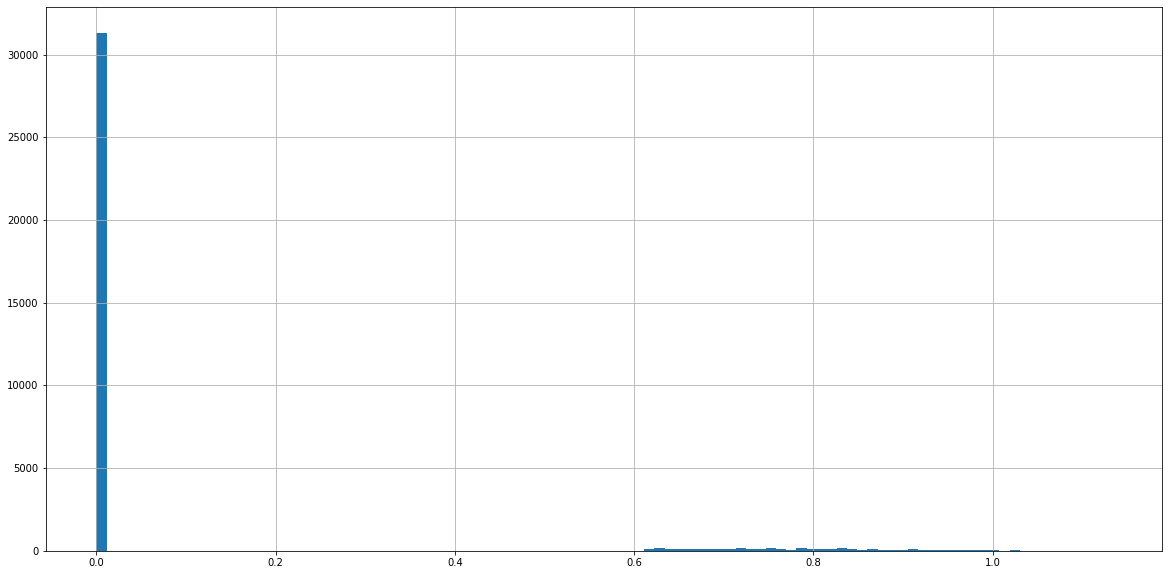

In [227]:
df.mp_score = df.mp_score.map(lambda x: 0 if x < 5000 else np.log2(x) / 20)

In [208]:
df[df.mp_score < 10000].mp_score = 1

/Users/robotics/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


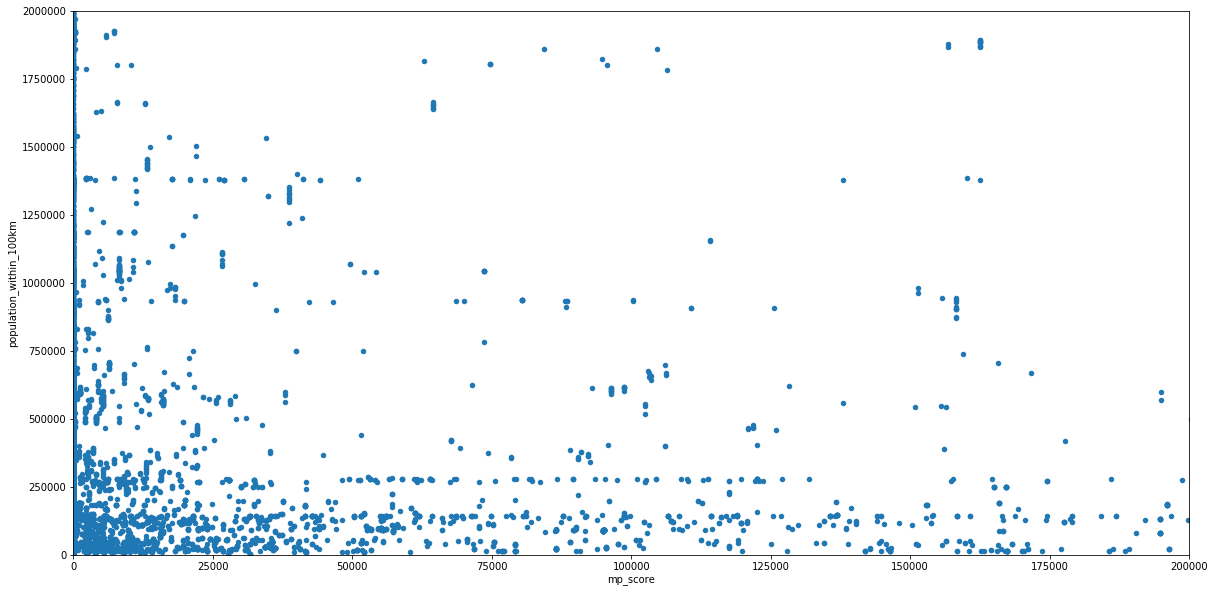

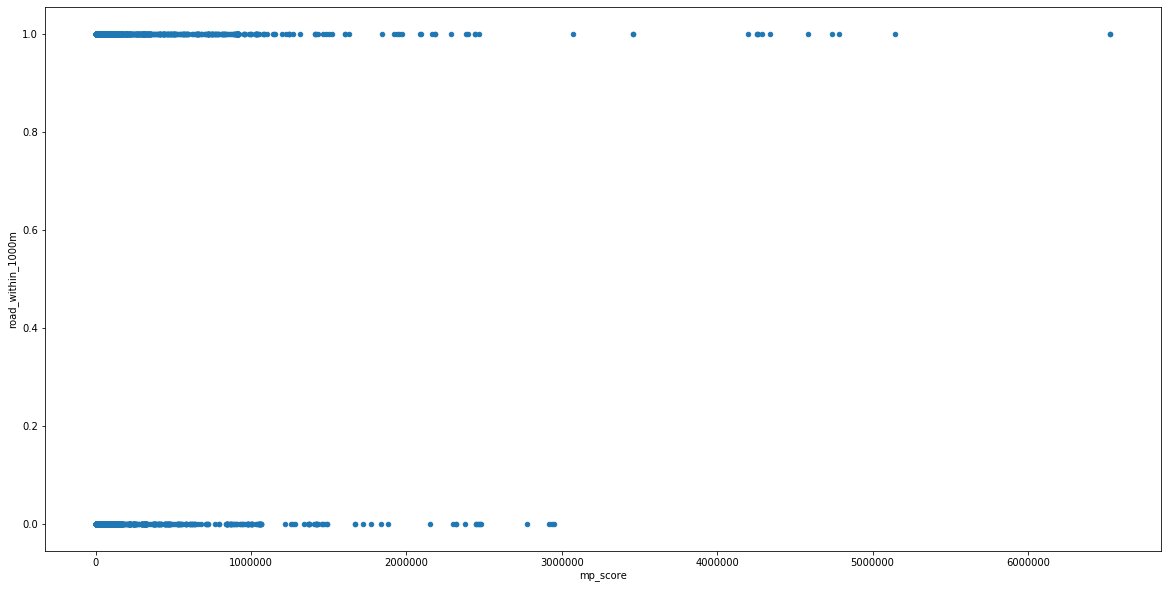

In [131]:
df.plot(x='mp_score', y='population_within_100km', kind='scatter',
        xlim=(0, 2 * 10 ** 5), ylim=(0, 2 * 10 ** 6))
df.plot(x='mp_score', y='road_within_1000m', kind='scatter')

In [ ]:
# Old stuff from merge_data -- might be useful.

# # For each cliff, we determine its accessibility score. We'll use this to
# # distinguish cliffs which are likely to have been explored.
# def set_accessibility(f):
#   """Determine if a feature is accessible from MP, population, and road data. """
#   cond1 = ee.Number(f.get('road_within_1000m'))
#   cond2 = ee.Number(f.get('population_within_30km')).gt(50000)
#   cond3 = ee.Number(f.get('population_within_100km')).gt(1000000)
#   # Checking if surrounding zone has been explored on documented on MP.
#   cond4 = ee.Number(get_mp_score_in_disk(f)).gt(10000)
#   cond = cond1.And(cond2.Or(cond3)).Or(cond4)
#   return f.set({'is_accessible': cond})


# # Function below may be as performant as a join, especially with huge maxError.
# # https://developers.google.com/earth-engine/best_practices#join-vs.-map-filter
# def determine_nearby_mp_presence(f):
#   """Use MP data to give score based on routes and views in a disk around feature."""
#   # looking at mp data within 500m of feature with very large error
#   blob = f.geometry().buffer(500).simplify(maxError=200)
#   close_mp = mp.filterBounds(blob)
#   num_rock_routes = close_mp.aggregate_sum('num_rock_routes')
#   num_views = close_mp.aggregate_sum('num_views')
#   return num_rock_routes.multiply(1000).add(num_views)

# # Now setting neighboring MP activity; this will be used as a measure of accessibility.
# merged = merged.map(determine_nearby_mp_presence)